In [1]:
import numpy as np
import xarray as xr
import pandas as pd
from minisom import MiniSom, asymptotic_decay
import matplotlib.pyplot as plt

In [2]:
ds_2t = xr.open_dataset("/glade/scratch/kiarar/ERA5_2T_1979_2021.nc")
ds_u = xr.open_dataset("/glade/scratch/kiarar/ERA5_U_winds_200_1979_2018.nc")
ds_v = xr.open_dataset("/glade/scratch/kiarar/ERA5_V_winds_200_1979_2018.nc")
ds_Z = xr.open_dataset("/glade/scratch/kiarar/ERA5_geopotential_winds_500_1979_2018.nc")

In [3]:
#slice data in time to make it match the other data... 
ds_2t = ds_2t.isel(time=slice(0,480))

In [4]:
#Stacking longitude and latitude into one column
subset_2t = ds_2t["VAR_2T"].stack(new=("latitude", "longitude"))
subset_u = ds_u["U"].stack(new=("latitude", "longitude")).drop("level")
subset_v = ds_v["V"].stack(new=("latitude", "longitude")).drop("level")
subset_Z = ds_Z["Z"].stack(new=("latitude", "longitude")).drop("level")

In [5]:
def normalize_data(data):
    """
    Function for normalizing data prior to training using z-score
    """
    return (data - np.nanmean(data)) / np.nanstd(data)

### Precipitation Data

In [6]:
ds1 = xr.open_mfdataset("/glade/u/home/kiarar/ERA5_CP_*_*.nc")

In [7]:
ds2 = xr.open_mfdataset("/glade/u/home/kiarar/ERA5_LSP_*_*.nc")

In [8]:
ds = ds1["CP"] + ds2["LSP"]

In [9]:
ds = ds.isel(time=slice(0,480))

In [10]:
subset_precip = ds.stack(new=("latitude", "longitude"))

In [11]:
subset_array = xr.concat([#normalize_data(subset_2t),
                          normalize_data(subset_u),
                          normalize_data(subset_v),
                          normalize_data(subset_Z),
                          normalize_data(subset_precip)], dim="new")

# Self-Organizing Map Training

In [54]:
som_grid_rows = 4
som_grid_columns = 3
input_length = subset_array.shape[1]

In [55]:
input_length

203444

In [56]:
sigma = 0.5 # Test 0.1-1
learning_rate = 0.005 # Test 0.0001-0.5
decay_function = asymptotic_decay

In [57]:
neighborhood_function = "gaussian"
topology = "rectangular"
activation_distance = 'euclidean'
random_seed = 1

In [58]:
som = MiniSom(
            som_grid_rows,
            som_grid_columns,
            input_length,
            sigma,
            learning_rate,
            decay_function,
            neighborhood_function,
            topology,
            activation_distance,
            random_seed)

In [59]:
data = subset_array.values
num_iteration = 1000
random_order = True
verbose = True

In [60]:
som.random_weights_init(data)

In [61]:
som.train(
        data,
        num_iteration,
        random_order,
        verbose)

 [ 1000 / 1000 ] 100% - 0:00:00 left 
 quantization error: 277.3914558879168


In [62]:
som.topographic_error(data)

0.45

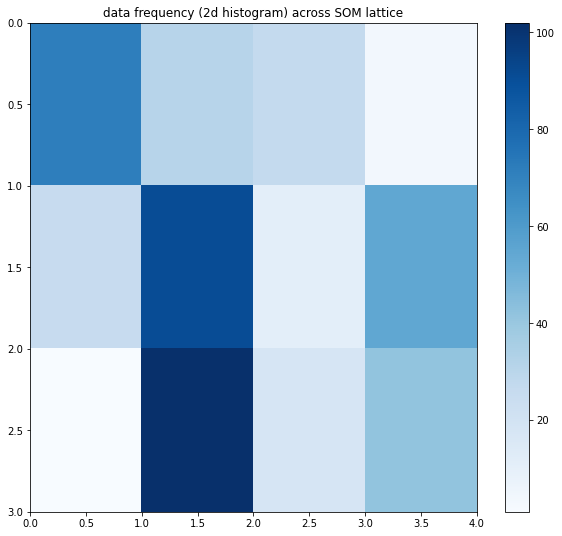

In [21]:
plt.figure(figsize=(10, 9))
frequencies = (som.activation_response(data))
plt.pcolormesh(frequencies, cmap='Blues') 
plt.colorbar()
plt.title("data frequency (2d histogram) across SOM lattice", fontsize=12)
plt.ylim(som_grid_rows, 0)  # flip the y axis to be the same as composite map axes later
#plt.savefig('All_data_freq.png', bbox_inches='tight', dpi=200)
plt.show()

# Visualizing Large-Scale Regimes

In [22]:
import cartopy
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
from itertools import product

In [23]:
keys = [i for i in product(range(som_grid_rows),range(som_grid_columns))]

In [24]:
winmap = {key: [] for key in keys}
# grab the indices for the data within the SOM lattice
for i, x in enumerate(data):
    winmap[som.winner(x)].append(i)

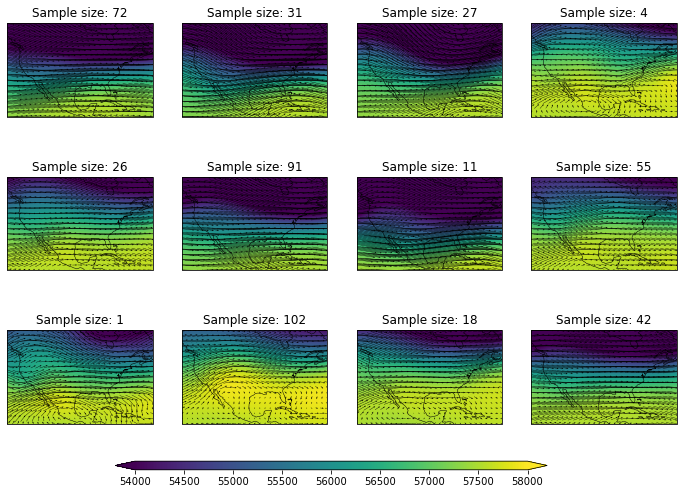

In [25]:
# create a figure using the same dimensions as SOM
fig, axs = plt.subplots(som_grid_rows, som_grid_columns, subplot_kw={'projection':ccrs.PlateCarree()}, figsize=(12,8))

# (1) loop through the SOM neurons, (2) grab data samples using SOM indices, (3) compute the mean for each SOM neuron, plot each 

for map_num in range(len(keys)):
    
    # the data
    lt = ds_Z["Z"][np.array(winmap[keys[map_num]])].coords['latitude'].values
    ln = ds_Z["Z"][np.array(winmap[keys[map_num]])].coords['longitude'].values
    
    # max temp
    temp_data = ds_Z["Z"][np.array(winmap[keys[map_num]])].mean(dim="time", skipna=True).values
    
    # plot
    cs = axs[keys[map_num][0],keys[map_num][1]].pcolormesh(ln, lt, temp_data, cmap="viridis", vmin=54000, vmax=58000,
                                                           transform=ccrs.PlateCarree())
    
    temp_datau = ds_u["U"][np.array(winmap[keys[map_num]])].mean(dim="time", skipna=True).values
    temp_datav = ds_v["V"][np.array(winmap[keys[map_num]])].mean(dim="time", skipna=True).values
    axs[keys[map_num][0],keys[map_num][1]].quiver(ln[::10], lt[::10], temp_datau[::10,::10], temp_datav[::10,::10], headwidth=4, minshaft=1.5, minlength=2, 
                                                          pivot='mid', color='k', scale=150, transform=ccrs.PlateCarree())
    
    # title
    axs[keys[map_num][0],keys[map_num][1]].set_title(f"Sample size: {int(frequencies.flatten()[map_num])}", fontsize=12)
    
    # kwargs
    axs[keys[map_num][0],keys[map_num][1]].coastlines(resolution='110m', color='k', linewidth=0.5, zorder=10)
    axs[keys[map_num][0],keys[map_num][1]].margins(x=0,y=0)
    
# colorbar stuff
cax = plt.axes([0.25, 0.075, 0.5, 0.015])
cbar = plt.colorbar(cs, orientation="horizontal", cax=cax, extend='both')
#cbar.set_ticks([-20,-10,0,10,20,30,40])
#cbar.ax.set_xticklabels([-20,-10,0,10,20,30,40],fontsize=12)
    
#plt.savefig('winds_freq.png', bbox_inches='tight', dpi=200)
plt.show()

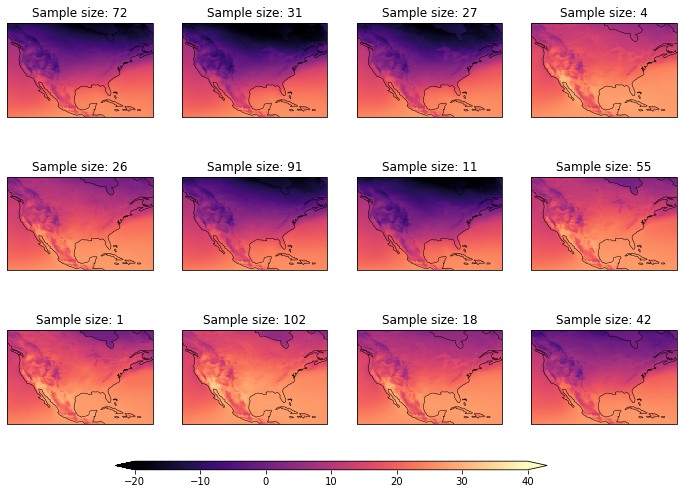

In [26]:
# create a figure using the same dimensions as SOM
fig, axs = plt.subplots(som_grid_rows, som_grid_columns, subplot_kw={'projection':ccrs.PlateCarree()}, figsize=(12,8))

# (1) loop through the SOM neurons, (2) grab data samples using SOM indices, (3) compute the mean for each SOM neuron, plot each 

for map_num in range(len(keys)):
    
    # the data
    lt = ds_2t['VAR_2T'][np.array(winmap[keys[map_num]])].coords['latitude'].values
    ln = ds_2t['VAR_2T'][np.array(winmap[keys[map_num]])].coords['longitude'].values
    
    # mean temp
    temp_data = ds_2t["VAR_2T"][np.array(winmap[keys[map_num]])].mean(dim="time", skipna=True).values
    
    # plot
    cs = axs[keys[map_num][0],keys[map_num][1]].pcolormesh(ln, lt, temp_data - 273.15, cmap="magma", vmin=-20, vmax=40, 
                                                           transform=ccrs.PlateCarree())
    
    # title
    axs[keys[map_num][0],keys[map_num][1]].set_title(f"Sample size: {int(frequencies.flatten()[map_num])}", fontsize=12)
    
    # kwargs
    axs[keys[map_num][0],keys[map_num][1]].coastlines(resolution='110m', color='k', linewidth=0.5, zorder=10)
    axs[keys[map_num][0],keys[map_num][1]].margins(x=0,y=0)
    
# colorbar stuff
cax = plt.axes([0.25, 0.075, 0.5, 0.015])
cbar = plt.colorbar(cs, orientation="horizontal", cax=cax, extend='both')
    
#plt.savefig('winds_freq.png', bbox_inches='tight', dpi=200)
plt.show()

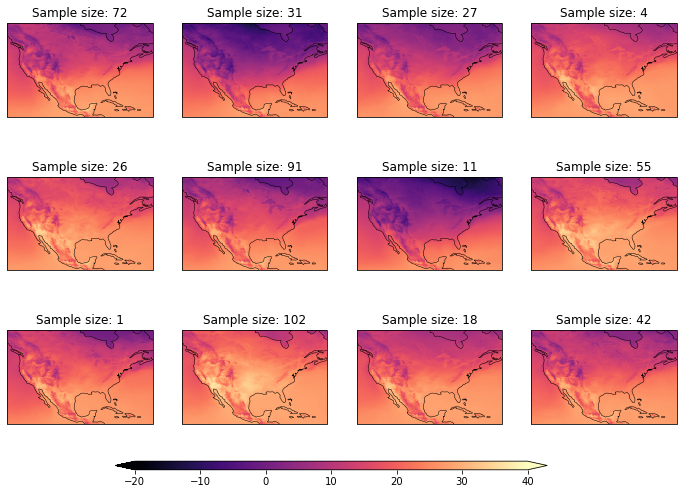

In [27]:
# create a figure using the same dimensions as SOM
fig, axs = plt.subplots(som_grid_rows, som_grid_columns, subplot_kw={'projection':ccrs.PlateCarree()}, figsize=(12,8))

# (1) loop through the SOM neurons, (2) grab data samples using SOM indices, (3) compute the mean for each SOM neuron, plot each 

for map_num in range(len(keys)):
    
    # the data
    lt = ds_2t['VAR_2T'][np.array(winmap[keys[map_num]])].coords['latitude'].values
    ln = ds_2t['VAR_2T'][np.array(winmap[keys[map_num]])].coords['longitude'].values
    
    # max temp
    temp_data = ds_2t["VAR_2T"][np.array(winmap[keys[map_num]])].max(dim="time", skipna=True).values
    
    # plot
    cs = axs[keys[map_num][0],keys[map_num][1]].pcolormesh(ln, lt, temp_data - 273.15, cmap="magma", vmin=-20, vmax=40, 
                                                           transform=ccrs.PlateCarree())
    
    # title
    axs[keys[map_num][0],keys[map_num][1]].set_title(f"Sample size: {int(frequencies.flatten()[map_num])}", fontsize=12)
    
    # kwargs
    axs[keys[map_num][0],keys[map_num][1]].coastlines(resolution='110m', color='k', linewidth=0.5, zorder=10)
    axs[keys[map_num][0],keys[map_num][1]].margins(x=0,y=0)
    
# colorbar stuff
cax = plt.axes([0.25, 0.075, 0.5, 0.015])
cbar = plt.colorbar(cs, orientation="horizontal", cax=cax, extend='both')
    
#plt.savefig('winds_freq.png', bbox_inches='tight', dpi=200)
plt.show()

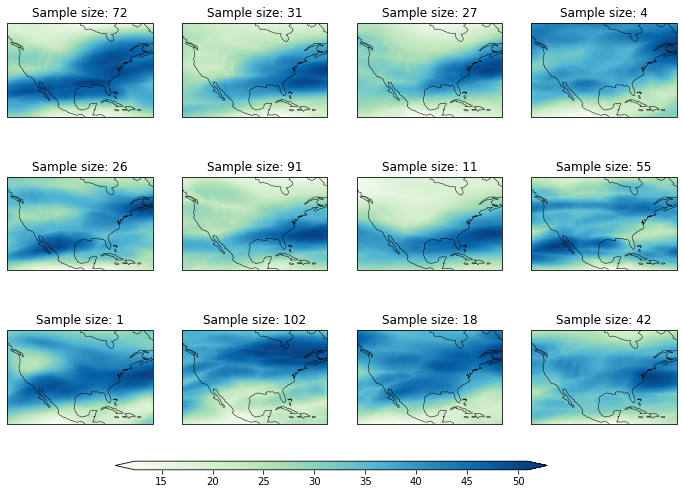

In [28]:
# create a figure using the same dimensions as SOM
fig, axs = plt.subplots(som_grid_rows, som_grid_columns, subplot_kw={'projection':ccrs.PlateCarree()}, figsize=(12,8))

# (1) loop through the SOM neurons, (2) grab data samples using SOM indices, (3) compute the mean for each SOM neuron, plot each 

for map_num in range(len(keys)):
    
    # the data
    lt = ds_u["U"][np.array(winmap[keys[map_num]])].coords['latitude'].values
    ln = ds_u["U"][np.array(winmap[keys[map_num]])].coords['longitude'].values
    
    # max temp
    temp_data = ds_u["U"][np.array(winmap[keys[map_num]])].max(dim="time", skipna=True).values
    
    # plot
    cs = axs[keys[map_num][0],keys[map_num][1]].pcolormesh(ln, lt, temp_data, cmap="GnBu", 
                                                           transform=ccrs.PlateCarree())
    
    # title
    axs[keys[map_num][0],keys[map_num][1]].set_title(f"Sample size: {int(frequencies.flatten()[map_num])}",fontsize=12)
    
    # kwargs
    axs[keys[map_num][0],keys[map_num][1]].coastlines(resolution='110m', color='k', linewidth=0.5, zorder=10)
    axs[keys[map_num][0],keys[map_num][1]].margins(x=0,y=0)
    
# colorbar stuff
cax = plt.axes([0.25, 0.075, 0.5, 0.015])
cbar = plt.colorbar(cs, orientation="horizontal", cax=cax, extend='both')
#cbar.set_ticks([-20,-10,0,10,20,30,40])
#cbar.ax.set_xticklabels([-20,-10,0,10,20,30,40],fontsize=12)
    
#plt.savefig('winds_freq.png', bbox_inches='tight', dpi=200)
plt.show()

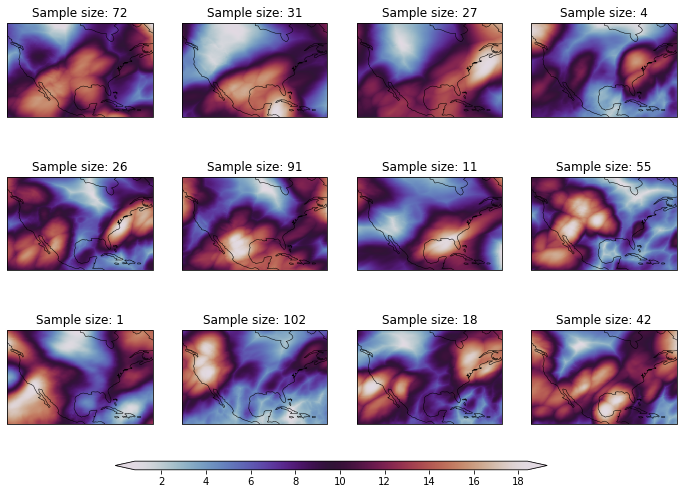

In [29]:
# create a figure using the same dimensions as SOM
fig, axs = plt.subplots(som_grid_rows, som_grid_columns, subplot_kw={'projection':ccrs.PlateCarree()}, figsize=(12,8))

# (1) loop through the SOM neurons, (2) grab data samples using SOM indices, (3) compute the mean for each SOM neuron, plot each 

for map_num in range(len(keys)):
    
    # the data
    lt = ds_v["V"][np.array(winmap[keys[map_num]])].coords['latitude'].values
    ln = ds_v["V"][np.array(winmap[keys[map_num]])].coords['longitude'].values
    
    # max temp
    temp_data = ds_v["V"][np.array(winmap[keys[map_num]])].max(dim="time", skipna=True).values
    
    # plot
    cs = axs[keys[map_num][0],keys[map_num][1]].pcolormesh(ln, lt, temp_data, cmap="twilight", 
                                                           transform=ccrs.PlateCarree())
    
    # title
    axs[keys[map_num][0],keys[map_num][1]].set_title(f"Sample size: {int(frequencies.flatten()[map_num])}", fontsize=12)
    
    # kwargs
    axs[keys[map_num][0],keys[map_num][1]].coastlines(resolution='110m', color='k', linewidth=0.5, zorder=10)
    axs[keys[map_num][0],keys[map_num][1]].margins(x=0,y=0)
    
# colorbar stuff
cax = plt.axes([0.25, 0.075, 0.5, 0.015])
cbar = plt.colorbar(cs, orientation="horizontal", cax=cax, extend='both')
#cbar.set_ticks([-20,-10,0,10,20,30,40])
#cbar.ax.set_xticklabels([-20,-10,0,10,20,30,40],fontsize=12)
    
#plt.savefig('winds_freq.png', bbox_inches='tight', dpi=200)
plt.show()

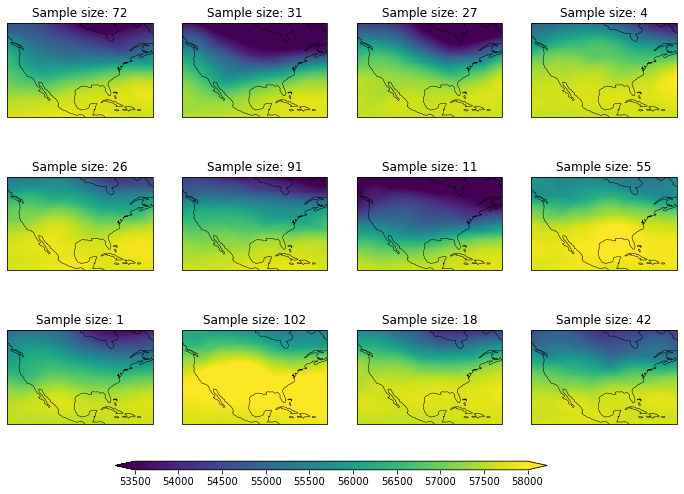

In [30]:
# create a figure using the same dimensions as SOM
fig, axs = plt.subplots(som_grid_rows, som_grid_columns, subplot_kw={'projection':ccrs.PlateCarree()}, figsize=(12,8))

# (1) loop through the SOM neurons, (2) grab data samples using SOM indices, (3) compute the mean for each SOM neuron, plot each 

for map_num in range(len(keys)):
    
    # the data
    lt = ds_Z["Z"][np.array(winmap[keys[map_num]])].coords['latitude'].values
    ln = ds_Z["Z"][np.array(winmap[keys[map_num]])].coords['longitude'].values
    
    # max temp
    temp_data = ds_Z["Z"][np.array(winmap[keys[map_num]])].max(dim="time", skipna=True).values
    
    # plot
    cs = axs[keys[map_num][0],keys[map_num][1]].pcolormesh(ln, lt, temp_data, cmap="viridis", vmin=53500, vmax=58000, 
                                                           transform=ccrs.PlateCarree())
    
    # title
    axs[keys[map_num][0],keys[map_num][1]].set_title(f"Sample size: {int(frequencies.flatten()[map_num])}", fontsize=12)
    
    # kwargs
    axs[keys[map_num][0],keys[map_num][1]].coastlines(resolution='110m', color='k', linewidth=0.5, zorder=10)
    axs[keys[map_num][0],keys[map_num][1]].margins(x=0,y=0)
    
# colorbar stuff
cax = plt.axes([0.25, 0.075, 0.5, 0.015])
cbar = plt.colorbar(cs, orientation="horizontal", cax=cax, extend='both')
#cbar.set_ticks([-20,-10,0,10,20,30,40])
#cbar.ax.set_xticklabels([-20,-10,0,10,20,30,40],fontsize=12)
    
#plt.savefig('winds_freq.png', bbox_inches='tight', dpi=200)
plt.show()

In [31]:
# compute the extreme precip cutoff
max_total_precip = ds.transpose("time", "latitude", "longitude").sum(["latitude", "longitude"]).chunk(
                               {'time': -1}).quantile([0.9], dim="time").values[0]

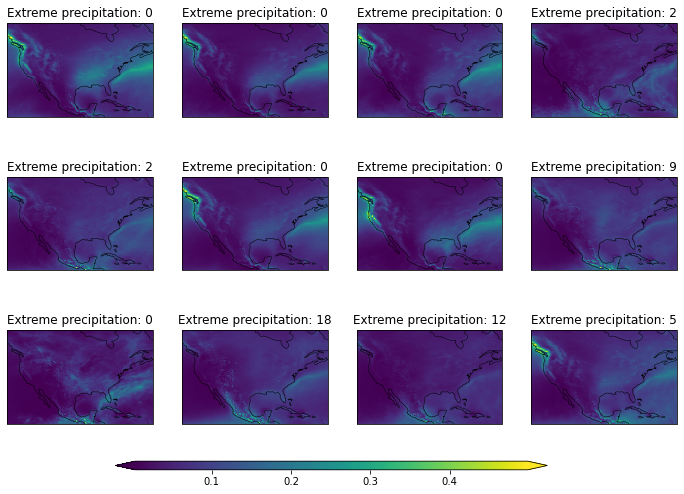

In [32]:
# create a figure using the same dimensions as SOM
fig, axs = plt.subplots(som_grid_rows, som_grid_columns, subplot_kw={'projection':ccrs.PlateCarree()}, figsize=(12,8))

# (1) loop through the SOM neurons, (2) grab data samples using SOM indices, (3) compute the mean for each SOM neuron, plot each 

for map_num in range(len(keys)):
    
    # the data
    lt = ds.transpose("time", "latitude", "longitude")[np.array(winmap[keys[map_num]])].coords['latitude'].values
    ln = ds.transpose("time", "latitude", "longitude")[np.array(winmap[keys[map_num]])].coords['longitude'].values
    
    # max temp
    temp_data = ds.transpose("time", "latitude", "longitude")[np.array(winmap[keys[map_num]])].mean(dim="time", skipna=True).values
    
    # plot
    cs = axs[keys[map_num][0],keys[map_num][1]].pcolormesh(ln, lt, temp_data, cmap="viridis", 
                                                           transform=ccrs.PlateCarree())
    
    # compute number of extreme events and plot title
    max_vals = ds.transpose("time", "latitude", "longitude")[np.array(winmap[keys[map_num]])].sum(["latitude", "longitude"]) >= max_total_precip
    axs[keys[map_num][0],keys[map_num][1]].set_title(f"Extreme precipitation: {int(max_vals.where(max_vals==0,1).sum('time').values)}", fontsize=12)
    
    # kwargs
    axs[keys[map_num][0],keys[map_num][1]].coastlines(resolution='110m', color='k', linewidth=0.5, zorder=10)
    axs[keys[map_num][0],keys[map_num][1]].margins(x=0,y=0)
    
# colorbar stuff
cax = plt.axes([0.25, 0.075, 0.5, 0.015])
cbar = plt.colorbar(cs, orientation="horizontal", cax=cax, extend='both')
#cbar.set_ticks([-20,-10,0,10,20,30,40])
#cbar.ax.set_xticklabels([-20,-10,0,10,20,30,40],fontsize=12)
    
#plt.savefig('winds_freq.png', bbox_inches='tight', dpi=200)
plt.show()

### Visualizing statistics of self-organizing maps

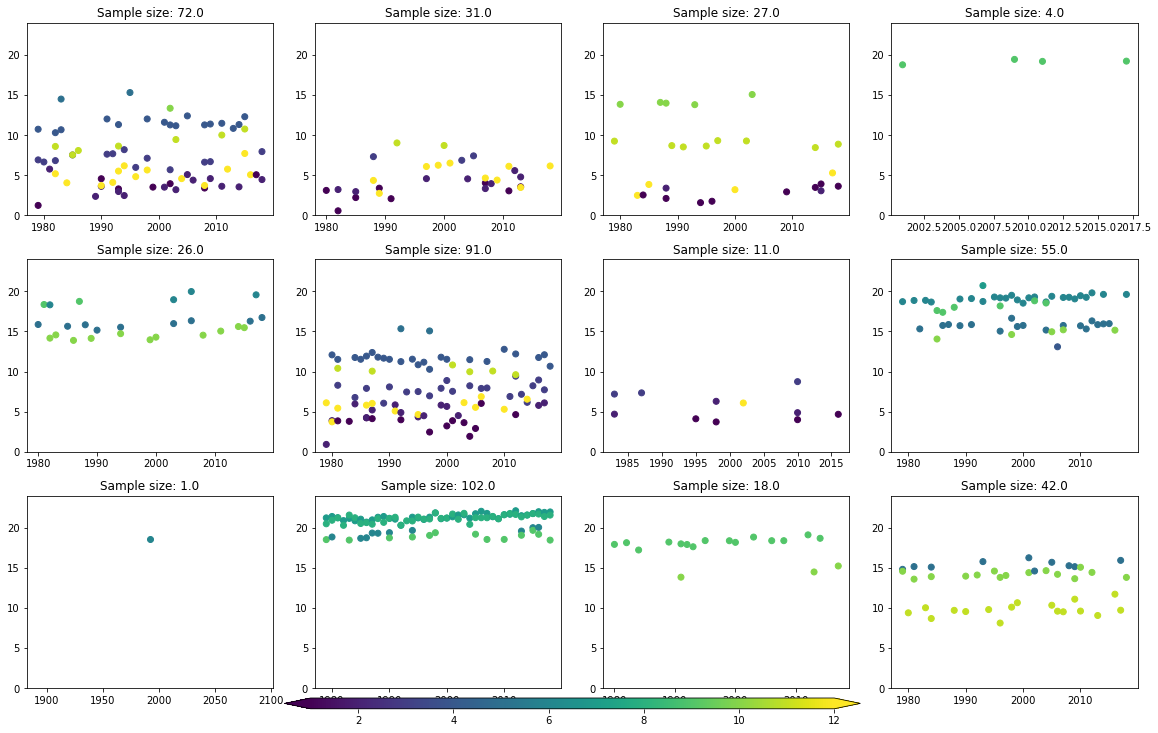

In [33]:
# view all SOM composite maps   (this cell takes a few minutes to run, especially if SOM lattice is large)

# mean us temperature

# create a figure using the same dimensions as SOM
fig, axs = plt.subplots(som_grid_rows, som_grid_columns, subplot_kw=dict(), figsize=(16,10))

# (1) loop through the SOM neurons, (2) grab data samples using SOM indices, (3) compute the mean for each SOM neuron, plot each 
for map_num in range(len(keys)):
    # the data
    year_data = ds_2t['VAR_2T'][np.array(winmap[keys[map_num]])].time.dt.year.values
    month_data = ds_2t['VAR_2T'][np.array(winmap[keys[map_num]])].time.dt.month.values
    
    temp_data = ds_2t['VAR_2T'][np.array(winmap[keys[map_num]])].mean(dim=['latitude','longitude']).values - 273.15
    # plot
    cs = axs[keys[map_num][0],keys[map_num][1]].scatter(year_data, temp_data, c=month_data, vmin=1, vmax=12, cmap='viridis')
    # title
    axs[keys[map_num][0],keys[map_num][1]].set_title(f"Sample size: {frequencies.flatten()[map_num]}", fontsize=12)
    axs[keys[map_num][0],keys[map_num][1]].set_ylim([0,24])

plt.tight_layout()
# colorbar stuff
cax = plt.axes([0.25, 0.01, 0.5, 0.015])
cbar = plt.colorbar(cs, orientation="horizontal", cax=cax, extend='both')   # color by month

plt.show()

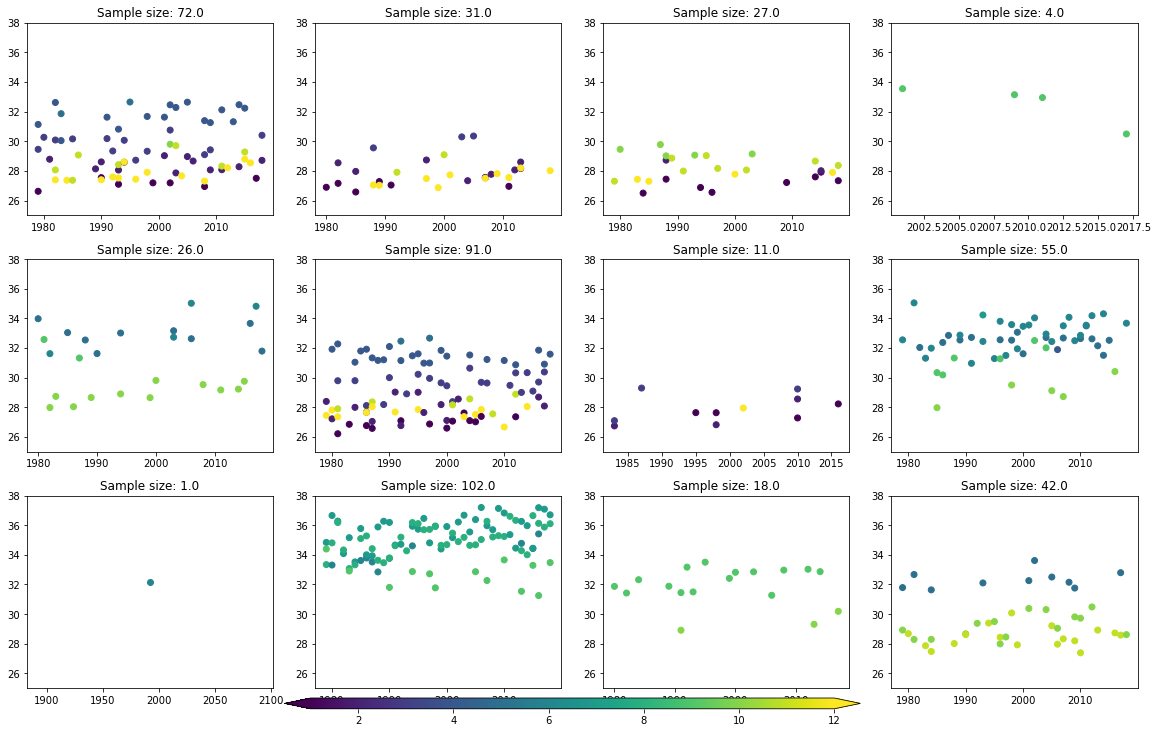

In [34]:
# view all SOM composite maps   (this cell takes a few minutes to run, especially if SOM lattice is large)

# max "us" temperature

# create a figure using the same dimensions as SOM
fig, axs = plt.subplots(som_grid_rows, som_grid_columns, subplot_kw=dict(), figsize=(16,10))

# (1) loop through the SOM neurons, (2) grab data samples using SOM indices, (3) compute the mean for each SOM neuron, plot each 
for map_num in range(len(keys)):
    # the data
    year_data = ds_2t['VAR_2T'][np.array(winmap[keys[map_num]])].time.dt.year.values
    month_data = ds_2t['VAR_2T'][np.array(winmap[keys[map_num]])].time.dt.month.values
    
    temp_data = ds_2t['VAR_2T'][np.array(winmap[keys[map_num]])].max(dim=['latitude','longitude']).values - 273.15
    # plot
    cs = axs[keys[map_num][0],keys[map_num][1]].scatter(year_data, temp_data, c=month_data, vmin=1, vmax=12, cmap='viridis')
    # title
    axs[keys[map_num][0],keys[map_num][1]].set_title(f"Sample size: {frequencies.flatten()[map_num]}", fontsize=12)
    axs[keys[map_num][0],keys[map_num][1]].set_ylim([25,38])

plt.tight_layout()
# colorbar stuff
cax = plt.axes([0.25, 0.01, 0.5, 0.015])
cbar = plt.colorbar(cs, orientation="horizontal", cax=cax, extend='both')  # color by month
plt.show()

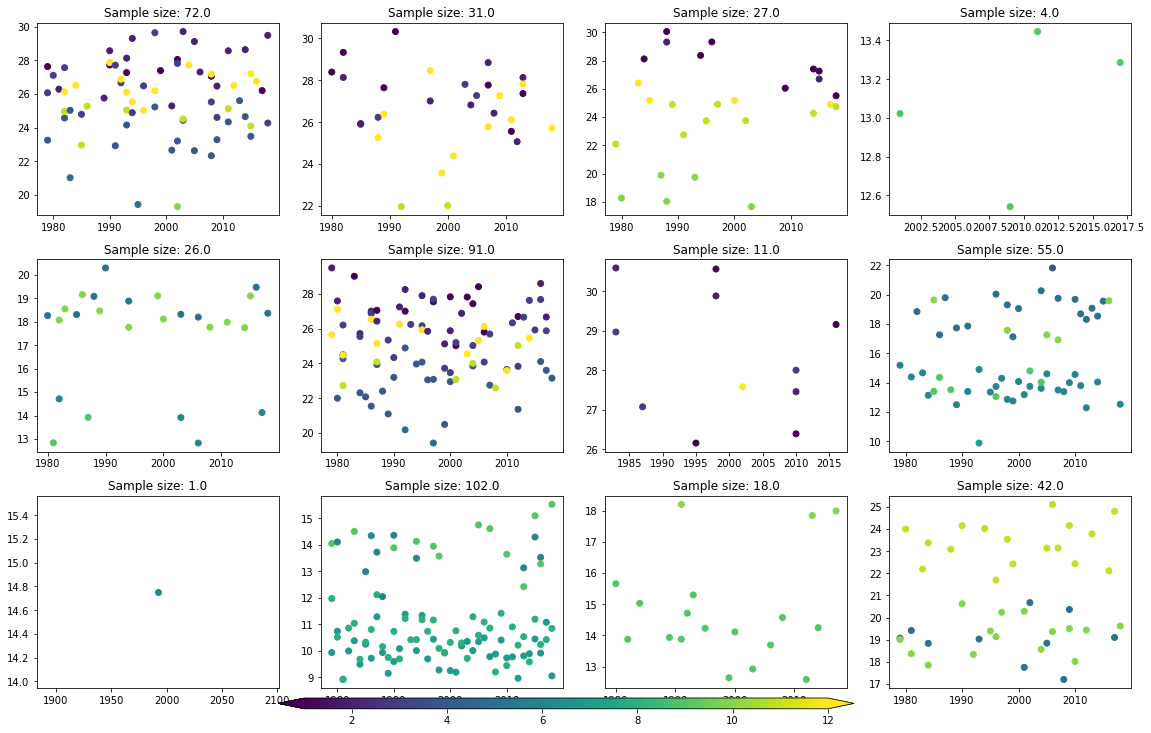

In [35]:
# mean us temperature

# create a figure using the same dimensions as SOM
fig, axs = plt.subplots(som_grid_rows, som_grid_columns, subplot_kw=dict(), figsize=(16,10))

# (1) loop through the SOM neurons, (2) grab data samples using SOM indices, (3) compute the mean for each SOM neuron, plot each 
for map_num in range(len(keys)):
    # the data
    year_data = ds_u["U"][np.array(winmap[keys[map_num]])].time.dt.year.values
    month_data = ds_u["U"][np.array(winmap[keys[map_num]])].time.dt.month.values
    
    temp_data = ds_u["U"][np.array(winmap[keys[map_num]])].mean(dim=['latitude','longitude']).values
    # plot
    cs = axs[keys[map_num][0],keys[map_num][1]].scatter(year_data, temp_data, c=month_data, vmin=1, vmax=12, cmap='viridis')
    # title
    axs[keys[map_num][0],keys[map_num][1]].set_title(f"Sample size: {frequencies.flatten()[map_num]}", fontsize=12)
    axs[keys[map_num][0],keys[map_num][1]]

plt.tight_layout()
# colorbar stuff
cax = plt.axes([0.25, 0.01, 0.5, 0.015])
cbar = plt.colorbar(cs, orientation="horizontal", cax=cax, extend='both')   # color by month

plt.show()

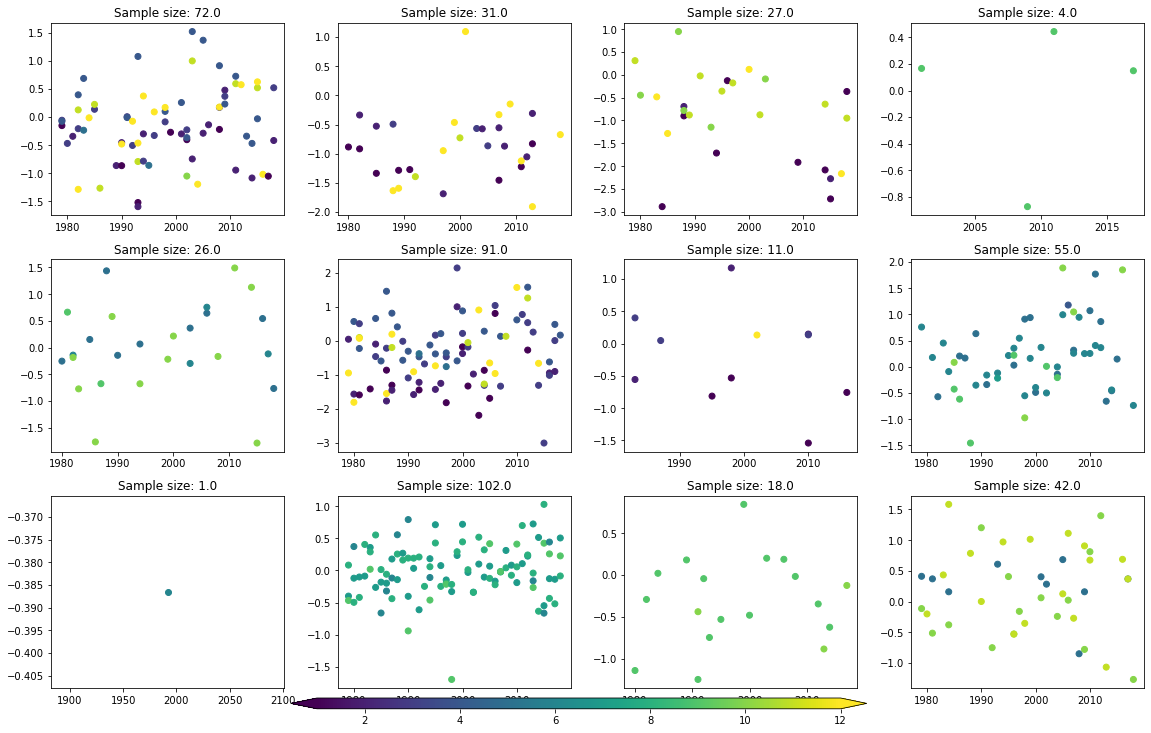

In [36]:
# view all SOM composite maps   (this cell takes a few minutes to run, especially if SOM lattice is large)

# mean us temperature

# create a figure using the same dimensions as SOM
fig, axs = plt.subplots(som_grid_rows, som_grid_columns, subplot_kw=dict(), figsize=(16,10))

# (1) loop through the SOM neurons, (2) grab data samples using SOM indices, (3) compute the mean for each SOM neuron, plot each 
for map_num in range(len(keys)):
    # the data
    year_data = ds_v["V"][np.array(winmap[keys[map_num]])].time.dt.year.values
    month_data = ds_v["V"][np.array(winmap[keys[map_num]])].time.dt.month.values
    
    temp_data = ds_v["V"][np.array(winmap[keys[map_num]])].mean(dim=['latitude','longitude']).values
    # plot
    cs = axs[keys[map_num][0],keys[map_num][1]].scatter(year_data, temp_data, c=month_data, vmin=1, vmax=12, cmap='viridis')
    # title
    axs[keys[map_num][0],keys[map_num][1]].set_title(f"Sample size: {frequencies.flatten()[map_num]}", fontsize=12)
    axs[keys[map_num][0],keys[map_num][1]]

plt.tight_layout()
# colorbar stuff
cax = plt.axes([0.25, 0.01, 0.5, 0.015])
cbar = plt.colorbar(cs, orientation="horizontal", cax=cax, extend='both')   # color by month

plt.show()

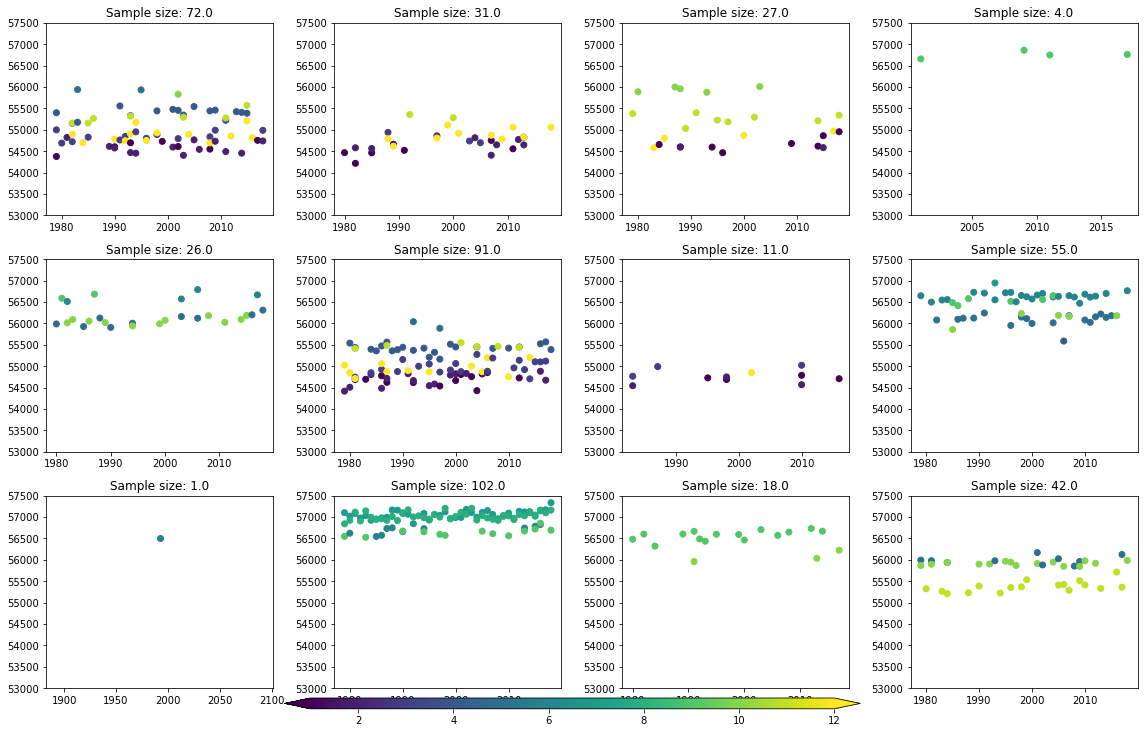

In [37]:
# view all SOM composite maps   (this cell takes a few minutes to run, especially if SOM lattice is large)

# mean us temperature

# create a figure using the same dimensions as SOM
fig, axs = plt.subplots(som_grid_rows, som_grid_columns, subplot_kw=dict(), figsize=(16,10))

# (1) loop through the SOM neurons, (2) grab data samples using SOM indices, (3) compute the mean for each SOM neuron, plot each 
for map_num in range(len(keys)):
    # the data
    year_data = ds_Z["Z"][np.array(winmap[keys[map_num]])].time.dt.year.values
    month_data = ds_Z["Z"][np.array(winmap[keys[map_num]])].time.dt.month.values
    
    temp_data = ds_Z["Z"][np.array(winmap[keys[map_num]])].mean(dim=['latitude','longitude']).values
    # plot
    cs = axs[keys[map_num][0],keys[map_num][1]].scatter(year_data, temp_data, c=month_data, vmin=1, vmax=12, cmap='viridis')
    # title
    axs[keys[map_num][0],keys[map_num][1]].set_title(f"Sample size: {frequencies.flatten()[map_num]}", fontsize=12)
    axs[keys[map_num][0],keys[map_num][1]].set_ylim([53000,57500])

plt.tight_layout()
# colorbar stuff
cax = plt.axes([0.25, 0.01, 0.5, 0.015])
cbar = plt.colorbar(cs, orientation="horizontal", cax=cax, extend='both')   # color by month

plt.show()

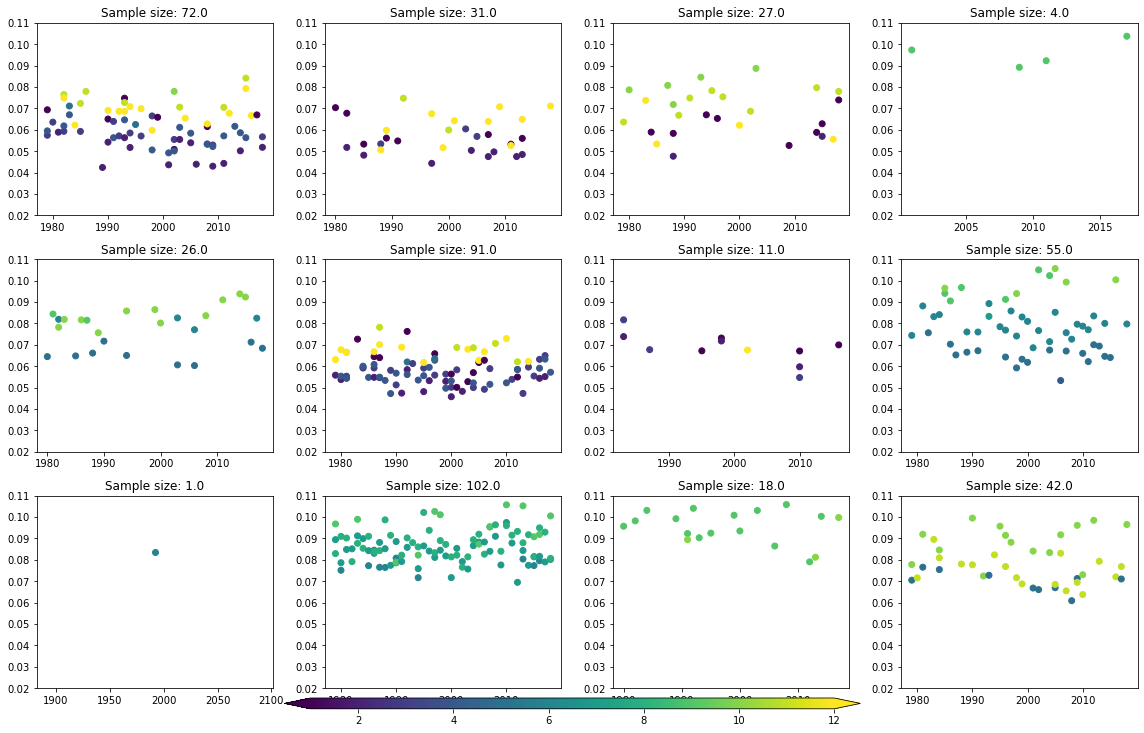

In [38]:
# view all SOM composite maps   (this cell takes a few minutes to run, especially if SOM lattice is large)

# mean us temperature

# create a figure using the same dimensions as SOM
fig, axs = plt.subplots(som_grid_rows, som_grid_columns, subplot_kw=dict(), figsize=(16,10))

# (1) loop through the SOM neurons, (2) grab data samples using SOM indices, (3) compute the mean for each SOM neuron, plot each 
for map_num in range(len(keys)):
    # the data
    year_data = ds.transpose("time", "latitude", "longitude")[np.array(winmap[keys[map_num]])].time.dt.year.values
    month_data = ds.transpose("time", "latitude", "longitude")[np.array(winmap[keys[map_num]])].time.dt.month.values
    
    temp_data = ds.transpose("time", "latitude", "longitude")[np.array(winmap[keys[map_num]])].mean(dim=['latitude','longitude']).values
    # plot
    cs = axs[keys[map_num][0],keys[map_num][1]].scatter(year_data, temp_data, c=month_data, vmin=1, vmax=12, cmap='viridis')
    # title
    axs[keys[map_num][0],keys[map_num][1]].set_title(f"Sample size: {frequencies.flatten()[map_num]}", fontsize=12)
    axs[keys[map_num][0],keys[map_num][1]].set_ylim([0.02,0.11])

plt.tight_layout()
# colorbar stuff
cax = plt.axes([0.25, 0.01, 0.5, 0.015])
cbar = plt.colorbar(cs, orientation="horizontal", cax=cax, extend='both')   # color by month

plt.show()

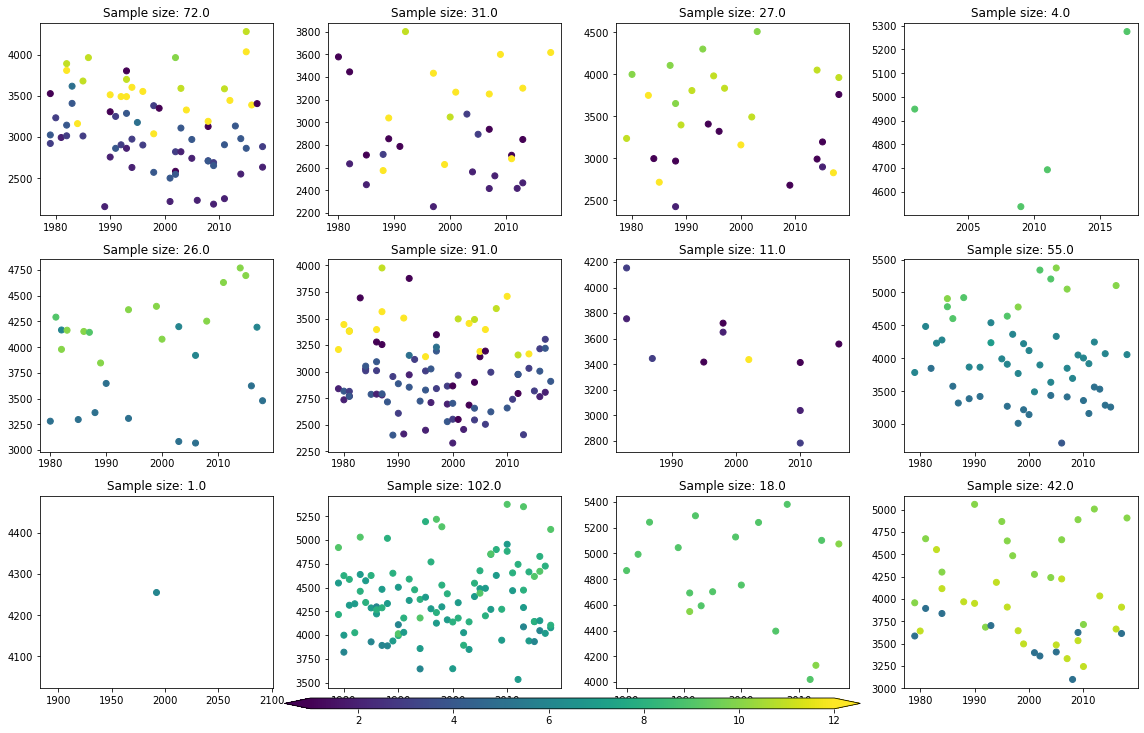

In [39]:
# view all SOM composite maps   (this cell takes a few minutes to run, especially if SOM lattice is large)

# mean us temperature

# create a figure using the same dimensions as SOM
fig, axs = plt.subplots(som_grid_rows, som_grid_columns, subplot_kw=dict(), figsize=(16,10))

# (1) loop through the SOM neurons, (2) grab data samples using SOM indices, (3) compute the mean for each SOM neuron, plot each 
for map_num in range(len(keys)):
    # the data
    year_data = ds.transpose("time", "latitude", "longitude")[np.array(winmap[keys[map_num]])].time.dt.year.values
    month_data = ds.transpose("time", "latitude", "longitude")[np.array(winmap[keys[map_num]])].time.dt.month.values
    
    temp_data = ds.transpose("time", "latitude", "longitude")[np.array(winmap[keys[map_num]])].sum(dim=['latitude','longitude']).values
    # plot
    cs = axs[keys[map_num][0],keys[map_num][1]].scatter(year_data, temp_data, c=month_data, vmin=1, vmax=12, cmap='viridis')
    # title
    axs[keys[map_num][0],keys[map_num][1]].set_title(f"Sample size: {frequencies.flatten()[map_num]}", fontsize=12)
   # axs[keys[map_num][0],keys[map_num][1]].set_ylim([0.02,0.11])

plt.tight_layout()
# colorbar stuff
cax = plt.axes([0.25, 0.01, 0.5, 0.015])
cbar = plt.colorbar(cs, orientation="horizontal", cax=cax, extend='both')   # color by month

plt.show()

### Histograms (for record of time)

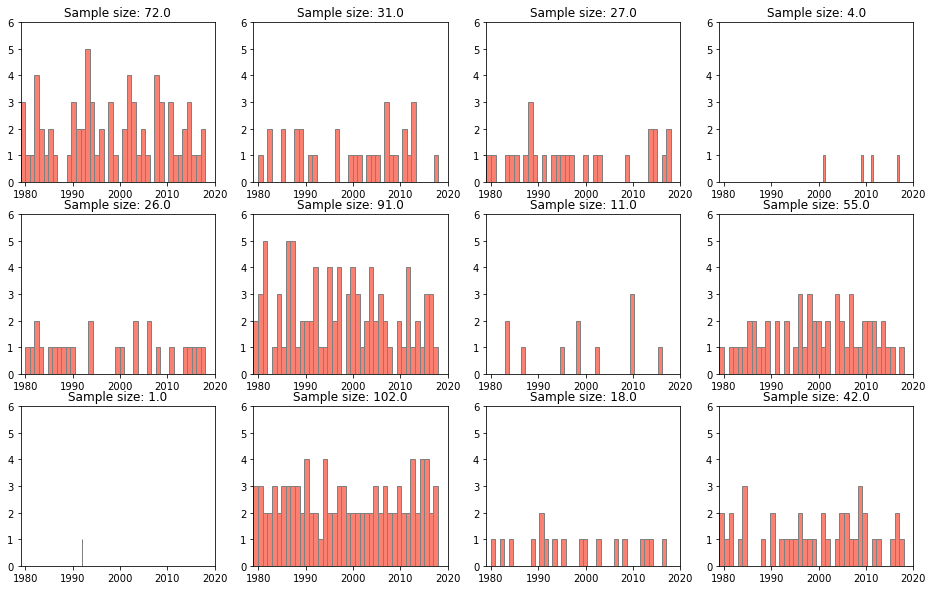

In [40]:
fig, axs = plt.subplots(som_grid_rows, som_grid_columns, subplot_kw=dict(), figsize=(16,10))
for map_num in range(len(keys)):
    temp_data = ds.transpose("time", "latitude", "longitude").coords['time'][np.array(winmap[keys[map_num]])].dt.year.values
    #temp_data = ds.transpose("time", "latitude", "longitude").sum(["latitude", "longitude"])[np.array(winmap[som_keys[map_num]])].values
    axs[keys[map_num][0],keys[map_num][1]].hist(temp_data, color='salmon', edgecolor='grey', bins=40)
    axs[keys[map_num][0],keys[map_num][1]].set_title(f"Sample size: {frequencies.flatten()[map_num]}", fontsize=12)
    axs[keys[map_num][0],keys[map_num][1]].set_ylim([0,6])
    axs[keys[map_num][0],keys[map_num][1]].set_xlim([1979,2020])
plt.show()

In [41]:
def replace_season(season):
    m = {'DJF':0,'MAM':1,'JJA':2,'SON':3}
    lst = []
    for n in season:
        lst.append(m[n])
    return lst

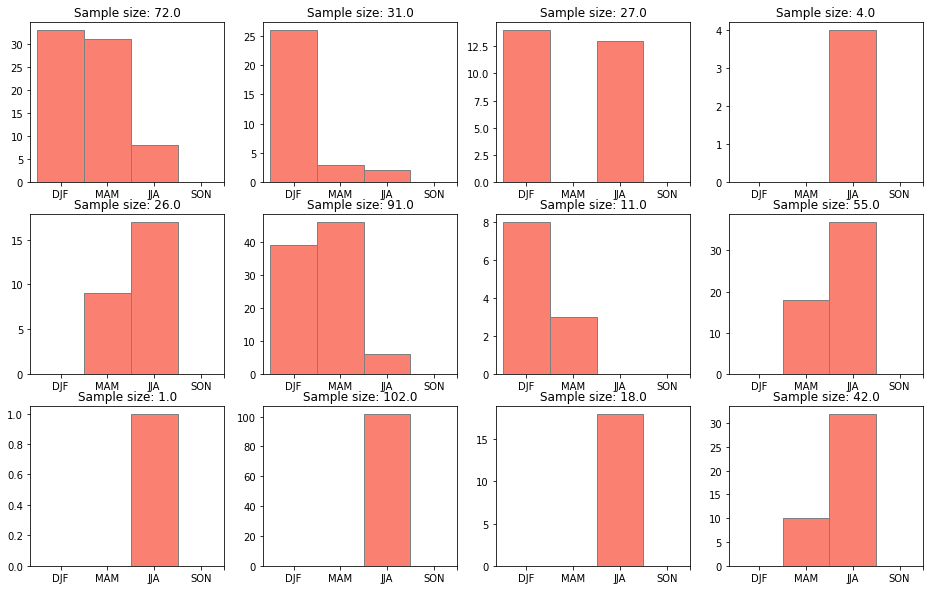

In [42]:
fig, axs = plt.subplots(som_grid_rows, som_grid_columns, subplot_kw=dict(), figsize=(16,10))
for map_num in range(len(keys)):
    temp_data = replace_season(ds.transpose("time", "latitude", "longitude").coords['time'][np.array(winmap[keys[map_num]])]['time.season'].values)
    #temp_data = ds.transpose("time", "latitude", "longitude").sum(["latitude", "longitude"])[np.array(winmap[som_keys[map_num]])].values
    axs[keys[map_num][0],keys[map_num][1]].hist(temp_data, color='salmon', edgecolor='grey', bins=[0,1,2,3], align='mid')
    axs[keys[map_num][0],keys[map_num][1]].set_title(f"Sample size: {frequencies.flatten()[map_num]}", fontsize=12)
    #axs[keys[map_num][0],keys[map_num][1]].set_ylim([0,50])
    #axs[keys[map_num][0],keys[map_num][1]].set_xlim([0,4])
    axs[keys[map_num][0],keys[map_num][1]].set_xticks([0.5,1.5,2.5,3.5,4])
    axs[keys[map_num][0],keys[map_num][1]].set_xticklabels(['DJF','MAM','JJA','SON',''])
plt.show()